In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one, _fit_transform_one
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import TransformerMixin
from sklearn.metrics import roc_auc_score

from collections import Counter
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100

***PandasFeatureUnion*** estimator adjusted to output dataframe, not as orginal FeatureUnion - the array. Used when we want preserve the format of pandas dataframe for further processing.

In [82]:
from scipy import sparse

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y,
                                        **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

## Hashing Trick

Building OneHot representation of categorical data restricting max number of columns.
Not recommended for forest like models (they don't perform well on OneHot data representation)
https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [18]:
class HashingTrick(TransformerMixin):
    def __init__(self, max_cols=1000):
        self._max_cols = max_cols
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **kwargs):
        max_cols = self._max_cols
        nrows = X.shape[0]
        new_X = np.zeros((nrows, max_cols))
        for i in range(X.shape[0]):
            line = X.iloc[i]
            column_label = [str(k) + str(v) for k, v in iter(dict(line).items())]
            hashed = list( map(lambda v: hash(v) % max_cols, column_label) )
            assert pd.notnull(hashed).any()
            encoded = np.zeros(max_cols)
            for h in hashed:
                encoded[h] = 1.0
            new_X[i, :] = encoded
        new_X = pd.DataFrame(new_X, columns=range(max_cols), index=X.index)
        return new_X

## Modulo hashing



Simple modulo hashing, changing text to numerical representation of data.

In [22]:
class SimpleHash(TransformerMixin):
    def __init__(self, mod=10000):
        self._mod = mod
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **kwargs):
        return X.applymap(lambda v: hash(v) % self._mod)

## Transformation based on value counts

Works well for feature in which counts (of particular values) convey some additional information. For example: popular names of cities in data set can correlate with their size of population (what could also be important).

In [25]:
class CounterTransformer(TransformerMixin):
    def __init__(self):
        self._counts = None
        
    def fit(self, X, y=None, **fit_params):
        self._counts = X.value_counts() / 1.0 / X.shape[0]
        return self
    
    def transform(self, X, **kwargs):
        return X.apply(lambda v: self._counts.get(v, 1))

class DFCounterTransformer(TransformerMixin):
    def __init__(self):
        self._transformers = {}
    
    def fit(self, X, y=None, **fit_params):
        self._transformers = {col: CounterTransformer().fit(X[col]) for col in X.columns}
        return self
    
    def transform(self, X, **kwargs):
        return pd.concat([
            self._transformers[col].transform(X[col]) for col in X.columns
        ], axis=1)

## Comparision of model performance using different hashing methods

In [89]:
df = pd.read_csv('.\data.csv')
split = int(df.shape[0] * 0.9)
y = df['cb'][:split]
y_test = df['cb'][split:]
X = df.drop('cb', axis=1)[:split]
X_test = df.drop('cb', axis=1)[split:]
X.head(10)

,bin,bin_country,user_ip_country,card_type,issuer_id,card_brand,headers_accept,headers_connection,headers_user_agent,headers_content_type,headers_content_length,headers_accept_encoding,headers_accept_language,timeoftotalpageload,timeofrequestresponse,windowhistory,navigatorvendor,navigatorappname,navigatorproduct,navigatorappversion,navigatorproductsub,navigatorappcodename,plugin,screen,language,useragent,donottrack,timezoneoffset,navigatorplatform,navigatorlanguages,navigatorjavaenabled,navigatorcookieenabled,flash_fonts,flash_fields,flash_devices,dwell_time,flight_time
0,453903,SE,SE,DEBIT,3109.0,VISA,*/*,keep-alive,"""Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...",NaN,NaN,"""gzip, deflate""",sv-se,4665,865,3.0,"""Apple Computer, Inc.""",Netscape,Gecko,"""5.0 (iPhone; CPU iPhone OS 10_2_1 like Mac OS...",20030107,Mozilla,"{""NavigatorPlugins"": {}, ""NavigatorMimeTypes"":...","{""ColorDepth"": 32, ""visibility"": {""hidden"": fa...",sv-se,"""Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...",1,-120.0,iPhone,"[""unknown""]",false,True,NaN,NaN,NaN,"{""avg"": 28.01714285714261, ""len"": 35, ""max"": 3...","{""avg"": 276.74482758620735, ""len"": 29, ""max"": ..."
1,464995,PH,PH,CREDIT,3155.0,VISA,*/*,keep-alive,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_...",NaN,NaN,"""gzip, deflate""",en-us,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,549828,AR,AR,CREDIT,10188.0,MASTERCARD,*/*,keep-alive,"""Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...",NaN,NaN,"""gzip, deflate, sdch, br""","""es-ES,es;q=0.8""",5263,1078,3.0,Google Inc.,Netscape,Gecko,"""5.0 (Windows NT 10.0; WOW64) AppleWebKit/537....",20030107,Mozilla,"{""NavigatorPlugins"": {""0"": {""name"": ""Widevine ...","{""ColorDepth"": 24, ""visibility"": {""hidden"": fa...",es,"""Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...",unknown,180.0,Win32,"[""es-ES"", ""es""]",false,True,NaN,NaN,NaN,"{""avg"": 130.94694915253834, ""len"": 59, ""max"": ...","{""avg"": 172.34904255319952, ""len"": 47, ""max"": ..."
3,450979,AR,AR,CREDIT,2742.0,VISA,"""application/javascript, */*;q=0.8""",Keep-Alive,"""Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537...",NaN,NaN,"""gzip, deflate""","""es-ES,es;q=0.5""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,490136,ZA,ZA,CREDIT,2499.0,VISA,*/*,keep-alive,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:53....,NaN,NaN,"""gzip, deflate, br""","""en-ZA,en-GB;q=0.8,en-US;q=0.5,en;q=0.3""",14040,851,14.0,NaN,Netscape,Gecko,5.0 (X11),20100101,Mozilla,"{""NavigatorPlugins"": {""0"": {""name"": ""Shockwave...","{""ColorDepth"": 24, ""visibility"": {""hidden"": fa...",en-ZA,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:53....,unspecified,-120.0,Linux x86_64,"[""en-ZA"", ""en-GB"", ""en-US"", ""en""]",false,True,"[""aakar"", ""Abyssinica SIL"", ""Andale Mono"", ""An...","{""Capabilities.os"": ""Linux 4.4.0-72-generic"", ...","{""Camera"": ""USB2.0 UVC WebCam (V4L2)"", ""Microp...","{""avg"": 161.7192647058824, ""len"": 34, ""max"": 5...","{""avg"": 333.41695652174025, ""len"": 23, ""max"": ..."
5,493493,BR,BR,CREDIT,3181.0,VISA,*/*,keep-alive,"""Mozilla/5.0 (Linux; Android 7.0; SM-G935F Bui...",NaN,NaN,"""gzip, deflate, sdch, br""","""pt-BR,pt;q=0.8,en-US;q=0.6,en;q=0.4""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,410684,SA,SA,CREDIT,4126.0,VISA,*/*,keep-alive,"""Mozilla/5.0 (Linux; Android 5.0; SAMSUNG SM-N...",NaN,NaN,"""gzip, deflate, sdch""","""en-GB,en;q=0.8,en-US;q=0.6,en;q=0.4""",10579,2396,3.0,Google Inc.,Netscape,Gecko,"""5.0 (Linux; Android 5.0; SAMSUNG SM-N900 Buil...",20030107,Mozilla,"{""NavigatorPlugins"": {}, ""NavigatorMimeTypes"":...","{""ColorDepth"": 32, ""visibility"": {""hidden"": fa...",en-GB,"""Mozilla/5.0 (Linux; Android 5.0; SAMSUNG SM-N...",unknown,-180.0,Linux armv7l,"[""en-GB"", ""en-US"", ""en""]",true,True,NaN,NaN,NaN,"{""avg"": 17.95417647115434, ""len"": 34, ""max"": 4...","{"

In [86]:
numeric_pipeline = Pipeline([
    ('SelectNumeric', FunctionTransformer(lambda df: df.select_dtypes(include=[np.number]), validate=False)),
    ('FillNA', FunctionTransformer(lambda df: df.fillna(-1), validate=False)),
])

categoric_pipeline = Pipeline([
    ('SelectCategoric', FunctionTransformer(lambda df: df.select_dtypes(exclude=[np.number]), validate=False)),
    ('FillNA', FunctionTransformer(lambda df: df.fillna(''), validate=False)),
    ('ToString', FunctionTransformer(lambda df: df.applymap(lambda a: str(a)), validate=False)),
#     ('Encode', HashingTrick(max_cols=1000))
    ('Encode', SimpleHash())
#     ('Encode', DFCounterTransformer())
])

feature_union = PandasFeatureUnion([
    ('numeric', numeric_pipeline),
    ('categoric', categoric_pipeline),
])

pipeline = Pipeline([
    ('transformed', feature_union),
    ('estimator', RandomForestClassifier(n_estimators=100, max_depth=6)),
])

pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('transformed', PandasFeatureUnion(n_jobs=1,
          transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('SelectNumeric', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001B6F2506730>, inv_kw_args=None,
          inverse_func=None, kw_args=No...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

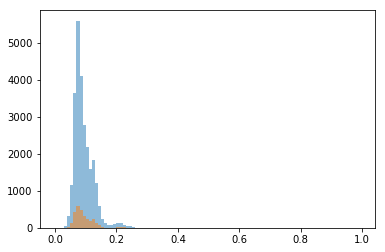

0.6242325749368003

In [87]:
prob_train = pipeline.predict_proba(X)[:,1]
prob_test = pipeline.predict_proba(X_test)[:,1]
bins = np.arange(0, 1, 0.01)
plt.hist(prob_train, bins=bins, alpha=0.5)
plt.hist(prob_test, bins=bins, alpha=0.5)
plt.show()
roc_auc_score(y_test, prob_test)

## Kernel Encoding

Performs well on features with some internal structure (we can build some kernels depending on it). Inspired by kernel regression.

In [66]:
def set_intersection(x1, x2):
    """
    Kernel
    Asign value based on number of co-occurences
    """
    x1 = set(eval(x1))
    x2 = set(eval(x2))
    x12 = x1.intersection(x2)
    if len(x1)>0 or len(x2)>0:
        return 2.0 * len(x12) / (len(x1) + len(x2))
    else: 
        return 0.0

    
class KernelTransformer(TransformerMixin):
    def __init__(self, kernel, n_columns):
        self._kernel = kernel
        self._n_columns = n_columns
        
    def fit(self, X, y=None, **fit_params):
        self._common_values = dict()
        for col in X.columns:
            self._common_values[col] =  list( zip(*Counter(X[col].dropna()).most_common(self._n_columns)) )[0]
        return self
    
    def transform(self, X, **kwargs):
        data_frames = []
        for col in X.columns:
            values = self._common_values[col]
            n_values = len(values)
            kernel_values = [[x if pd.isnull(x) else self._kernel(x, value) for value in values] for x in X[col]]
            data_frames.append(pd.DataFrame(kernel_values, columns = list(map(lambda a: str(col) + "#" + str(a), values)), index=X.index))
        return pd.concat(data_frames, axis=1)

In [1]:
fonts_pipeline = Pipeline([
    ('SelectFonts', FunctionTransformer(lambda df: df[['flash_fonts', 'navigatorlanguages']], validate=False)),
    ('KernelTransformer', KernelTransformer(set_intersection, 5)),
    ('FillNA', FunctionTransformer(lambda df: df.fillna(-1), validate=False)),
])
fonts_pipeline.fit_transform(X)

# Feature Selection

## Feature Importance Selector

Pick columns based on their score from sklearn's estimator's importance feature.
Might be a little bit biased and prefer columns whitch overfit to train data.

In [71]:
class RFFeatureImportanceSelector(TransformerMixin):
    def __init__(self, num_features=30, estimator=RandomForestClassifier()):
        self.estimator = estimator
        self.good_columns = []
        self.num_features = num_features
        
    def fit(self, X, y, **kwargs):
        self.estimator.fit(X, y)
        feature_importance = self.estimator.feature_importances_
        columns_sorted_by_importance = X.columns[np.argsort(feature_importance)][::-1]
        self.good_columns = columns_sorted_by_importance[:self.num_features].tolist()
        print(self.good_columns)
        return self
    
    def transform(self, X, y=None, **kwargs):
        return X[self.good_columns]

## Shuffle Selector

Check the performance of estimator, while predicting on shuffled data. When the cost (prediction loss/metric) is similar despite whether
particular column is shuffled or not, it means that it (the column) is not important for prediction accuracy.

In [72]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

class ShuffleSelector(TransformerMixin):
    def __init__(self, num_features=30, shuffle_count=5, estimator=RandomForestClassifier(), func_to_min=log_loss):
        self.estimator = estimator
        self.good_columns = []
        self.num_features = num_features
        self.func_to_min = func_to_min
        self.shuffle_count = shuffle_count
    
    def shuffle_procedure(self, X, y):
        column_costs = {}
        X = X.copy()
        for col in X.columns:
            scores = []
            for i in range(self.shuffle_count):
                shuffled_col = np.random.permutation(X[col])
                old_col = X[col]
                X[col] = shuffled_col
                shuffled_predictions = self.estimator.predict_proba(X)[:, 1]
                shuffled_score = self.func_to_min(y, shuffled_predictions)
                scores.append(shuffled_score)
                X[col] = old_col
            column_costs[col] = np.mean(scores)
        self.cost_df = pd.DataFrame(column_costs, index=['cost_value']).T
        return self.cost_df.sort_values('cost_value', ascending=False)  
    
    def fit(self, X, y, **kwargs):
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, train_size=.75)
        self.estimator.fit(xtrain, ytrain)
        self.df_cost_column = self.shuffle_procedure(xvalid, yvalid)
        self.good_columns = self.df_cost_column[:self.num_features].index.tolist()
        print(self.good_columns)
        print(self.df_cost_column)
        return self
    
    def transform(self, X, y=None, **kwargs):
        return X[self.good_columns]
        

## One Column Selector

Estimate the models based on only one column at a time, check the performance metric. Can perform well when there is not much interactions between features.

In [73]:
class TrainOnOneColumnSelector(TransformerMixin):    
    def __init__(self, num_features=30, shuffle_count=5, estimator=RandomForestClassifier(), func_to_min=log_loss):
        self.estimator = estimator
        self.good_columns = []
        self.num_features = num_features
        self.func_to_min = func_to_min
        self.shuffle_count = shuffle_count
    
    def train_procedure(self, X, y):
        column_costs = {}
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=.75)
        for col in X_train.columns:
            self.estimator = RandomForestClassifier(n_estimators=10)
            self.estimator.fit(X_train[[col]], y_train)
            predictions = self.estimator.predict_proba(X_valid[[col]])[:, 1]
            score = self.func_to_min(y_valid, predictions)
            column_costs[col] = score
        self.cost_df = pd.DataFrame(column_costs, index=['cost_value']).T
        return self.cost_df.sort_values('cost_value', ascending=False)  
    
    def fit(self, X, y, **kwargs):
        self.df_cost_column = self.train_procedure(X, y)
        self.good_columns = self.df_cost_column[:self.num_features].index.tolist()
        print (self.good_columns)
        return self
    
    def transform(self, X, y=None, **kwargs):
        return X[self.good_columns]

## AUC metric for different hashing and selection method

C:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


['headers_content_type', 'headers_content_length', 'timezoneoffset', 'windowhistory', 'issuer_id', 'headers_accept', 'card_brand', 'bin_country', 'headers_connection', 'card_type']
                         cost_value
headers_content_type       1.371982
headers_content_length     1.371982
timezoneoffset             1.342557
windowhistory              1.318914
issuer_id                  1.296455
headers_accept             1.290850
card_brand                 1.277656
bin_country                1.272053
headers_connection         1.268403
card_type                  1.266487
user_ip_country            1.211521
bin                        1.184465
headers_user_agent         1.161446
headers_accept_language    1.147382
timeoftotalpageload        1.131267
headers_accept_encoding    1.082327
timeofrequestresponse      1.078906
navigatorvendor            1.077729
navigatorappname           1.060254
navigatorproduct           1.057215
navigatorproductsub        1.012941
navigatorappversion        

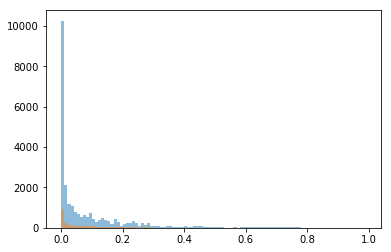

0.6167754970571871

In [88]:
max_feat = 10

categoric_pipeline = Pipeline([
    ('SelectCategoric', FunctionTransformer(lambda df: df.select_dtypes(exclude=[np.number]), validate=False)),
    ('FillNA', FunctionTransformer(lambda df: df.fillna(''), validate=False)),
    ('ToString', FunctionTransformer(lambda df: df.applymap(lambda a: str(a)), validate=False)),
#     ('Encode', HashingTrick(max_cols=1000)),
    ('Encode', SimpleHash()),
#     ('Encode', DFCounterTransformer()),
])

feature_union = PandasFeatureUnion([
    ('numeric', numeric_pipeline),
    ('categoric', categoric_pipeline),
])

pipeline = Pipeline([
    ('transformed', feature_union),
#     ('selection', RFFeatureImportanceSelector(num_features=max_feat)),
    ('selection', ShuffleSelector(num_features=max_feat)),
#     ('selection', TrainOnOneColumnSelector(num_features=max_feat)),
    ('estimator', RandomForestClassifier(n_estimators=100)),
])

pipeline.fit(X, y)

prob_train = pipeline.predict_proba(X)[:,1]
prob_test = pipeline.predict_proba(X_test)[:,1]
bins = np.arange(0, 1, 0.01)
plt.hist(prob_train, bins=bins, alpha=0.5)
plt.hist(prob_test, bins=bins, alpha=0.5)
plt.show()
roc_auc_score(y_test, prob_test)